In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.multitest import multipletests
# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-10-07 13:47:54.197248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 13:47:55.191438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [3]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

## Config

In [4]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [5]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel level

In [39]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
# predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [40]:
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))
pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### DICE

In [6]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))

In [7]:
mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [8]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [9]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['HUP224', 'HUP225', 'HUP229', 'HUP230', 'HUP235', 'HUP238',
       'HUP246', 'HUP247', 'HUP249', 'HUP250', 'HUP253', 'HUP257',
       'HUP263', 'HUP266'], dtype=object)

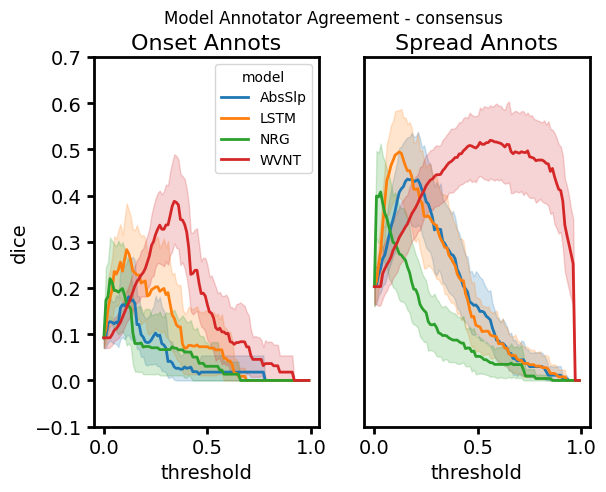

In [45]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((-.1,.7))
axs[0].set_title('Onset Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.1,.7))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('Spread Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

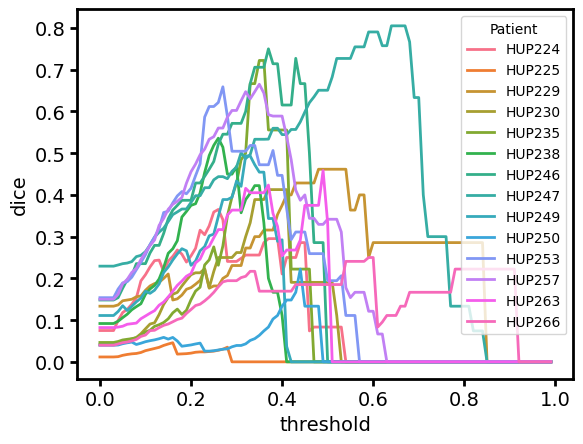

In [46]:
fig,ax = plt.subplots()
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'WVNT')],x='threshold',y='dice',hue='Patient',errorbar=None,legend=True)
fig.savefig(ospj(figpath,f'pt_WVNT_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

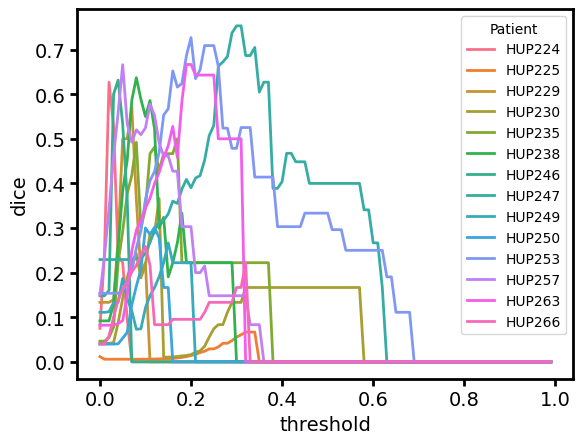

In [47]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='dice',hue='Patient',errorbar=None,)

In [48]:
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.074534,0.076503,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.127660,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.164706,0.166667,ueo_consensus_strict_dice,0.075000
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.074534,0.076503,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.127660,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.164706,0.166667,ueo_consensus_strict_dice,0.075000
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.074534,0.076503,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.127660,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.164706,0.166667,ueo_consensus_strict_dice,0.075000
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.074534,0.076503,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.127660,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.164706,0.166667,ueo_consensus_strict_dice,0.075000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.075949,0.077778,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.129032,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.166667,0.168421,ueo_consensus_strict_dice,0.076433


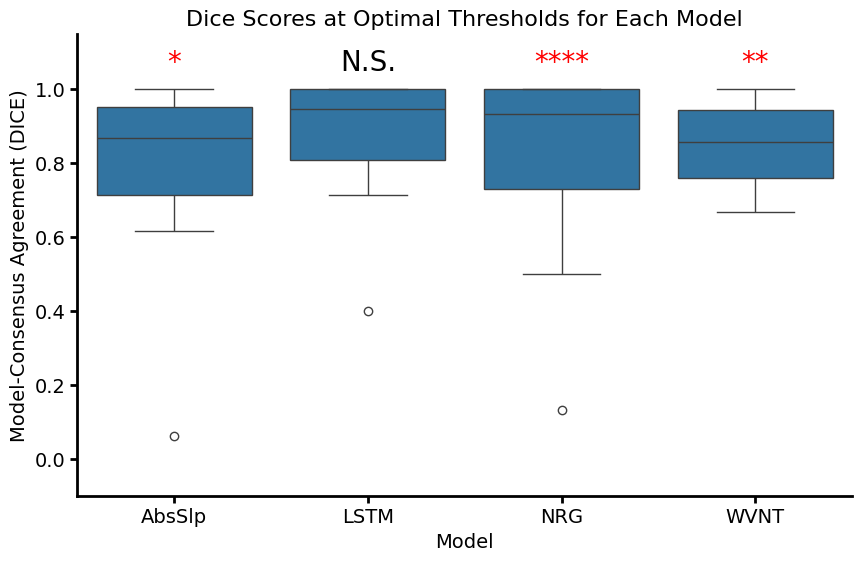

In [10]:
optimal_thresholds = mdl_preds_long.loc[mdl_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset"]]

# Step 2: Create a box plot of dice scores at optimal thresholds for each model
plt.figure(figsize=(10, 6))
sns.boxplot(data=optimal_thresholds, x='model', y='dice')
plt.title('Dice Scores at Optimal Thresholds for Each Model')
plt.xlabel('Model')
plt.ylabel('Model-Consensus Agreement (DICE)')
sns.despine()
sigs = ['*','N.S.','****','**']
cols = ["red","black","red","red"]
for i in range(4):
    plt.text(i,1.05,sigs[i],fontsize=20,color=cols[i],ha='center')
plt.ylim([-.1,1.15])
plt.show()



In [16]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = mdl_preds_long.groupby(['Patient', 'model', 'threshold'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
optimal_thresholds = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
optimal_thresholds = optimal_thresholds[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)

print(optimal_thresholds)

   Patient   model  threshold      dice
0   HUP224  AbsSlp       0.08  0.421578
1   HUP224    LSTM       0.03  0.536765
2   HUP224     NRG       0.00  0.103765
3   HUP224    WVNT       0.26  0.341602
4   HUP225  AbsSlp       0.00  0.017493
5   HUP225    LSTM       0.59  0.066667
6   HUP225     NRG       0.66  0.083333
7   HUP225    WVNT       0.86  0.111111
8   HUP229  AbsSlp       0.07  0.533333
9   HUP229    LSTM       0.07  0.633540
10  HUP229     NRG       0.01  0.388889
11  HUP229    WVNT       0.51  0.611722
12  HUP230  AbsSlp       0.15  0.204647
13  HUP230    LSTM       0.13  0.316849
14  HUP230     NRG       0.01  0.265467
15  HUP230    WVNT       0.41  0.487485
16  HUP235  AbsSlp       0.15  0.392487
17  HUP235    LSTM       0.12  0.494613
18  HUP235     NRG       0.04  0.430556
19  HUP235    WVNT       0.36  0.536838
20  HUP238  AbsSlp       0.13  0.539683
21  HUP238    LSTM       0.11  0.681746
22  HUP238     NRG       0.01  0.661147
23  HUP238    WVNT       0.26  0.541407


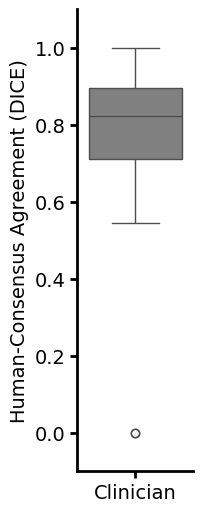

In [12]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
for i_r, row in consensus_annots.iterrows():
    annot_sets = row.ueo
    die = 0
    for annot in annot_sets:
        die += f1_score(annot,row.ueo_consensus)
    consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(consensus_annots,y='f1',color='grey')
plt.xticks([0],['Clinician'])
plt.ylabel('Human-Consensus Agreement (DICE)')
plt.ylim([-.1,1.1])
sns.despine()

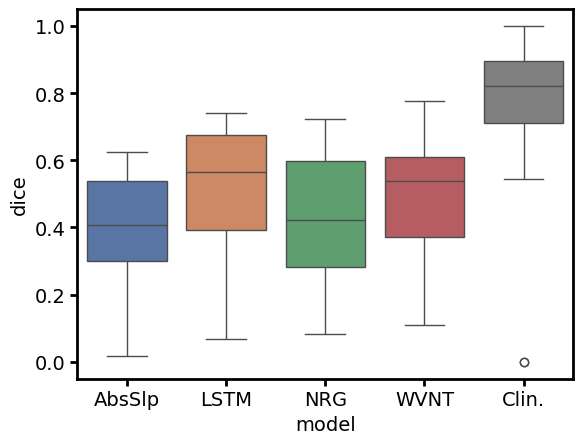

In [13]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_thresholds,consensus_annots[["model","dice"]]])
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]))


In [14]:
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_thresholds[optimal_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=955.0, pvalue=5.9002680138299145e-08)
LSTM
MannwhitneyuResult(statistic=877.0, pvalue=6.878124477495689e-06)
NRG
MannwhitneyuResult(statistic=915.0, pvalue=7.507215406769204e-07)
WVNT
MannwhitneyuResult(statistic=891.0, pvalue=3.111204431781117e-06)


Text(0.5, 1.0, 'Suppervised Annotation')

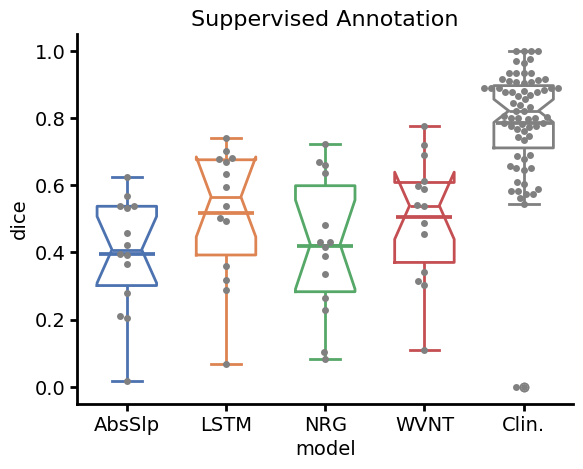

In [17]:
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Suppervised Annotation")

### Kappa

In [ ]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [ ]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_loose_any_kappa' 'sec_chs_loose_bool'
 'sec_chs_loose_consensus_kappa' 'sec_chs_strict'
 'sec_chs_strict_any_kappa' 'sec_chs_strict_bool'
 'sec_chs_strict_consensus_kappa' 'sec_consensus' 'stim' 'threshold'
 'to_annotate' 'ueo_any' 'ueo_chs_loose' 'ueo_chs_loose_any_kappa'
 'ueo_chs_loose_bool' 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,sec_chs_loose_bool,sec_chs_loose_consensus_kappa,sec_chs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[True, True, True, True, True, True, True, Fal...",0.267516,0.306455,"[True, True, True, True, True, True, False, Fa...",0.477558,"[True, True, True, True, True, True, True, Fal...",0.337949,0.43282,ueo_chs_strict_consensus_kappa,0.33526
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[False, False, False, False, False, False, Fal...",0.240088,0.436827,"[False, False, False, False, False, False, Fal...",0.110366,"[False, False, False, False, False, False, Fal...",0.129887,0.21001,ueo_chs_strict_consensus_kappa,0.28035


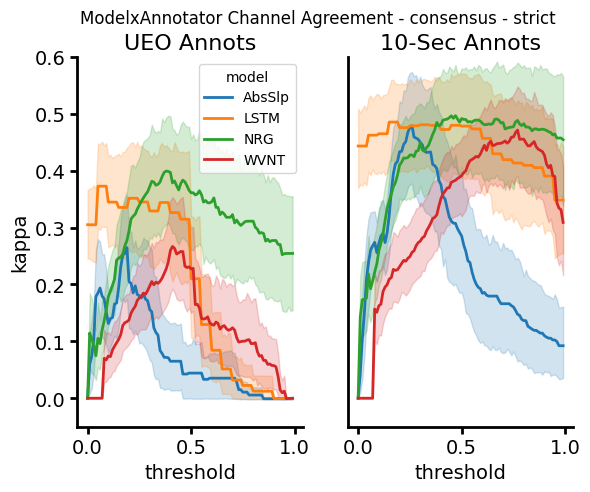

In [ ]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.despine(ax=axs[0])
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
sns.despine(ax=axs[1])
fig.suptitle(f'ModelxAnnotator Channel Agreement - {anntype} - {mdl_anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_agreement_{anntype}-{mdl_anntype}.pdf'),transparent=True)

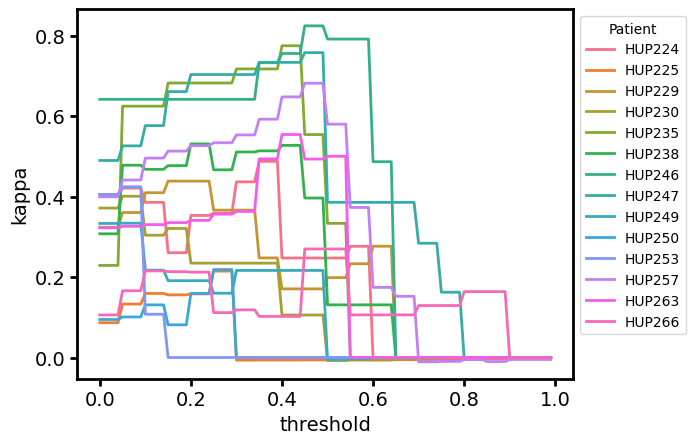

In [ ]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='kappa',hue='Patient',errorbar=None,)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Getting optimal threshold

In [ ]:
mask = mdl_preds_sorted.model == 'NRG'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')[f'ueo_{anntype}_{mdl_anntype}_dice'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')[f'sec_{anntype}_{mdl_anntype}_dice'].mean()

In [ ]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean([ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()]]))

0.38
0.45
0.41500000000000004


## Region Agreement Optimization

### Kappa

In [ ]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_regions_wkappa.pkl"))
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [ ]:
mdl_preds_sorted[[col for col in mdl_preds_sorted.columns if 'kappa' in col]].fillna(0,inplace=True)
melt_cols = [f'ueo_rs_{mdl_anntype}_{anntype}_kappa',f'sec_rs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.364964,0.292683,0.292683,0.466258,0.317647,0.414986,ueo_rs_strict_consensus_kappa,0.364964
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",1.000000,1.000000,1.000000,0.364964,0.472727,0.364964,ueo_rs_strict_consensus_kappa,1.000000


In [ ]:
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'ueo_rs_strict',
       'ueo_rs_loose', 'sec_rs_strict', 'sec_rs_loose', 'all_rs',
       'ueo_consensus_rs', 'ueo_any_rs', 'sec_consensus_rs', 'sec_any_rs',
       'ueo_rs_strict_consensus_kappa', 'ueo_rs_strict_any_kappa',
       'ueo_rs_loose_consensus_kappa', 'ueo_rs_loose_any_kappa',
       'sec_rs_strict_consensus_kappa', 'sec_rs_strict_any_kappa',
       'sec_rs_loose_consensus_kappa', 'sec_rs_loose_any_kappa'],
      dtype='object')

Text(0.5, 0.98, 'ModelxAnnotator Region Agreement - consensus - strict')

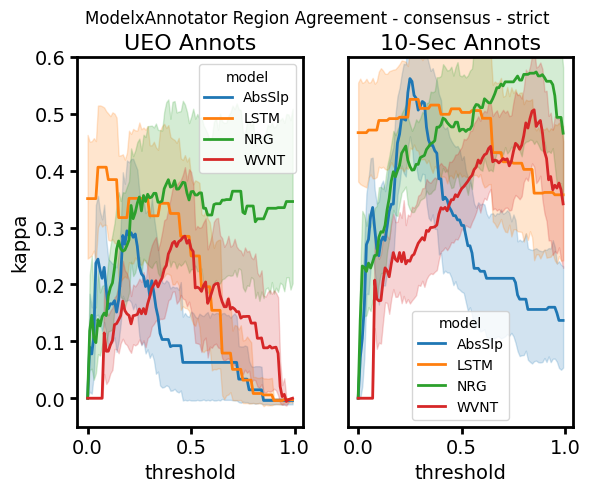

In [ ]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'ModelxAnnotator Region Agreement - {anntype} - {mdl_anntype}')

In [ ]:
mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
14800,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14801,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.364964,0.292683,0.292683,0.466258,0.317647,0.414986,sec_rs_strict_consensus_kappa,0.359621
14802,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14803,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14804,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",1.000000,1.000000,1.000000,0.364964,0.472727,0.364964,sec_rs_strict_consensus_kappa,0.472727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29595,HUP266,HUP266_phaseII,WVNT,0.0,418859.4191,418859.4191,0.98,[],[],"[RB02, RC02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.594595,0.594595,0.594595,sec_rs_strict_consensus_kappa,0.594595
29596,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,0.99,[],[],[],...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
29597,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,0.99,[],[],"[RC02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.328358,0.328358,0.328358,sec_rs_strict_consensus_kappa,0.328358
29598,HUP266,HUP266_phaseII,NRG,0.0,418859.4191,418859.4191,0.99,[],[],"[RB01, RB02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.594595,0.594595,0.594595,sec_rs_strict_consensus_kappa,0.594595


### Getting optimal threshold

In [ ]:
mask = mdl_preds_sorted.model == 'NRG'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_rs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_rs_strict_consensus_kappa'].mean()

NameError: name 'mdl_preds_sorted' is not defined

In [ ]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean((ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()])))

0.19
0.25
0.22


In [ ]:
sum((mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM'))

3700

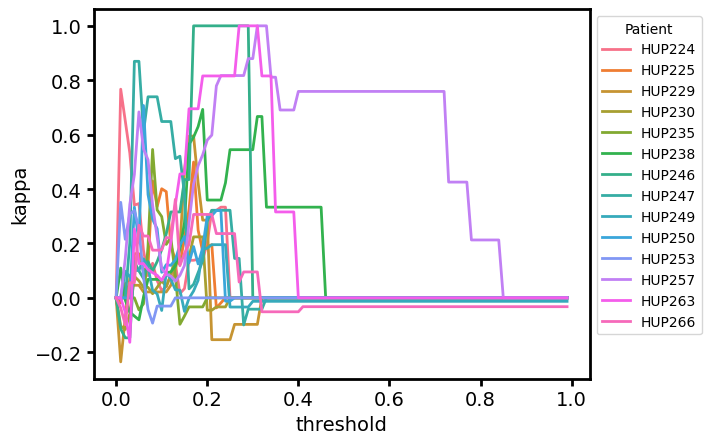

In [ ]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'AbsSlp')],x='threshold',y='kappa',hue='Patient',errorbar=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KDE Model Predictions

In [18]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0) & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

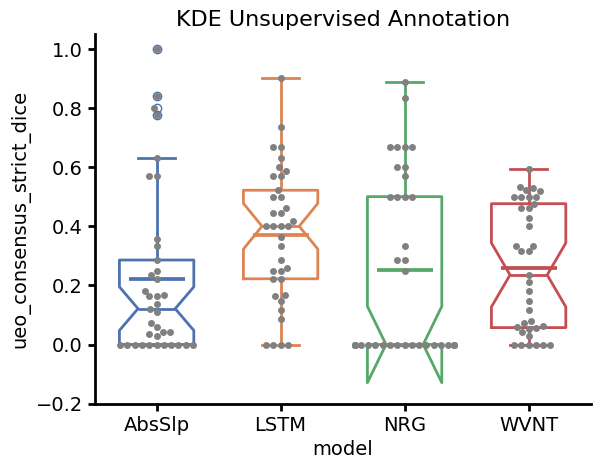

In [20]:
bx = sns.boxplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
sns.pointplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Annotation")

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

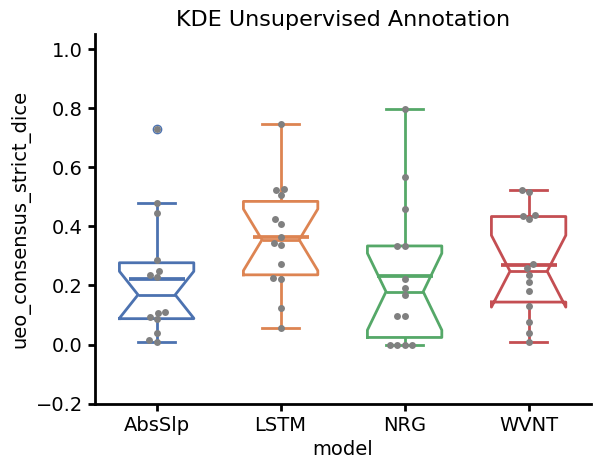

In [21]:
pt_pred_channels_wdice = pred_channels_wdice.groupby(['Patient','model'])[['ueo_consensus_strict_dice']].mean()
bx = sns.boxplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
sns.pointplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Annotation")

In [29]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl].ueo_consensus_strict_dice,pred_channels_wdice[pred_channels_wdice.model == j_mdl].ueo_consensus_strict_dice)
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl].ueo_consensus_strict_dice,
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl].ueo_consensus_strict_dice)
        print(d)
        all_ps.append(p)
        print(p)

WVNT WVNT
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
WVNT NRG
0.02642465732547653
MannwhitneyuResult(statistic=778.0, pvalue=0.3036077004842037)
WVNT AbsSlp
0.14885900378550831
MannwhitneyuResult(statistic=799.0, pvalue=0.214926154030054)
WVNT LSTM
-0.5095232521345681
MannwhitneyuResult(statistic=506.5, pvalue=0.054568607165637696)
NRG WVNT
-0.02642465732547653
MannwhitneyuResult(statistic=591.0, pvalue=0.3036077004842037)
NRG NRG
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
NRG AbsSlp
0.10298368698873936
MannwhitneyuResult(statistic=638.0, pvalue=0.6053196573401702)
NRG LSTM
-0.44239037530415704
MannwhitneyuResult(statistic=500.5, pvalue=0.043384323322410406)
AbsSlp WVNT
-0.14885900378550831
MannwhitneyuResult(statistic=570.0, pvalue=0.214926154030054)
AbsSlp NRG
-0.10298368698873936
MannwhitneyuResult(statistic=731.0, pvalue=0.6053196573401702)
AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
AbsSlp LSTM
-0.5810627353489841
MannwhitneyuResult(statisti